# Compressive Brazilian Test
 using Argiope & MechanicalTest



In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import MechanicalTest.model_brazilian_test as model
import argiope as ag
import pandas as pd
import numpy as np
import compmod2 as cp2
import os, subprocess, time, local_settings, time
%matplotlib nbagg

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['contour.negative_linestyle'] = 'solid'

# USEFUL FUNCTIONS
def create_dir(path):
  try:
    os.mkdir(path)
  except:
    pass

## Settings

In [26]:
# SETTINGS
workdir   = "./workdir/"
outputdir = "./outputs/"
label   = "BT"

create_dir(workdir)
create_dir(workdir + outputdir)     

## Material and Sample definition using compmodModel definition

In [27]:
#-------------------------------------------------------------------------------
# MESH DEFINITIONS
def element_map(mesh):
    mesh.elements.loc[mesh.elements.type.argiope == "tri3", ("type", "solver", "")] = "CPE3" 
    mesh.elements.loc[mesh.elements.type.argiope == "quad4", ("type", "solver", "")] = "CPE4R" 
    return mesh
    
    
def tool_material_map(mesh):
    mesh.elements["materials"] = "SAMPLE_MAT" 
    return mesh

def material_map_comp(mesh):
    mesh.elements.materials = ["MAT{0}".format(i+1) for i in range(len(mesh.elements.index))]
    return mesh


# Geometrical definition of the model in mm

R=5.
parts = {
    "sample" : model.Sample2D_BT( R = R, lc1 = R/45., 
                                   gmsh_path = "gmsh",
                                   file_name = "dummy1", 
                                   workdir = workdir, 
                                   gmsh_space = 2, 
                                   gmsh_options = "-algo delquad",
                                   element_map = element_map,
                                   material_map = material_map_comp),
    "fixtool" : model.Sample2D_Tool( hy = -.2,  lc = 1., 
                                   gmsh_path = "gmsh",
                                   file_name = "dummy2", 
                                   workdir = workdir, 
                                   gmsh_space = 2, 
                                   gmsh_options = "-algo delquad",
                                   element_map = element_map,
                                   material_map = tool_material_map),
    "movingtool" : model.Sample2D_Tool( hy = 2*R,  lc = 1., 
                                   gmsh_path = "gmsh",
                                   file_name = "dummy3", 
                                   workdir = workdir, 
                                   gmsh_space = 2, 
                                   gmsh_options = "-algo delquad",
                                   element_map = element_map,
                                   material_map = tool_material_map)
}

In [28]:
# Make the mesh a first time to konw the number of elts
parts["sample"].make_mesh()    
Ne = parts["sample"].mesh.elements.shape[0]

# Material def using compmod
dist = cp2.distributions.Uniform()
xt, x = dist.discretize(Ne, xmax = 1.)
np.random.shuffle(x)

# homogeneous parameters
E= 100e3
nu=.3
yield_stress = 2000

Can not extract 'surfaces' from 'line2'


In [29]:
# heterogeneous parameters : Yield Stress
if True:
    Delta_yield = 100. # MPa var on yield stress 
    materials = [ag.materials.ElasticPerfectlyPlastic(
                                     label = "MAT{0}".format(i+1), 
                                     young_modulus = E, 
                                     poisson_ratio = nu, 
                                     yield_stress = (Delta_yield*(x[i]-.5) + yield_stress)) 
                                     for i in range(Ne)]


    
materials.append(ag.materials.Hollomon(label = "SAMPLE_MAT", strain_data_points = 100,
                                   young_modulus = 210e3,
                                   poisson_ratio = 0.3,
                                   hardening_exponent = 0.3,
                                   yield_stress = 200))

In [32]:

#-------------------------------------------------------------------------------
# STEP DEFINTIONS

steps = [
        model.Step2D_BT(name = "LOADING1",
                         control_type = "disp", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 200,
                         controlled_value = -3.,
                         field_output_frequency = 1)
        
        ]                                                                                                  

model_EF = model.BrazilianTest2D(label = label, 
                      parts = parts, 
                      steps = steps, 
                      materials = materials, 
                      solver = "abaqus", 
                      solver_path = local_settings.ABAQUS_PATH,
                      workdir = workdir,
                      verbose = True,
                      friction = 0.0)



In [33]:
print("1: Preprocessing ----------------------------------")
%time model_EF.write_input()

1: Preprocessing ----------------------------------
Can not extract 'surfaces' from 'line2'
Can not extract 'surfaces' from 'line2'
Can not extract 'surfaces' from 'line2'
Wall time: 6.7 s


## Model checking

Mesh building and quality checking.

In [18]:
parts.keys()

dict_keys(['sample', 'fixtool', 'movingtool'])

In [19]:
parts["sample"].mesh.elements.head()

conn                   materials         sets                  type  \
           n0    n1    n2    n3           ALL_ELEMENTS SURFACE   all argiope   
                                                                               
element                                                                        
285      6871  6880  6885  6881      MAT1         True   False  True   quad4   
286      2088  2089  2356  2353      MAT2         True   False  True   quad4   
287      2938  2965  3202  3175      MAT3         True   False  True   quad4   
288      6507  6469  6414  6497      MAT4         True   False  True   quad4   
289      1874  1907  2214  2141      MAT5         True   False  True   quad4   

               surfaces                       
        solver  SURFACE                       
                     f1     f2     f3     f4  
element                                       
285      CPE4R    False  False  False  False  
286      CPE4R    False  False  False  False  
287      CPE4R    False  False  False  False  
288      CPE4R    False  False  False  False  
289      CPE4R    False  False  False  False

<IPython.core.display.Javascript object>


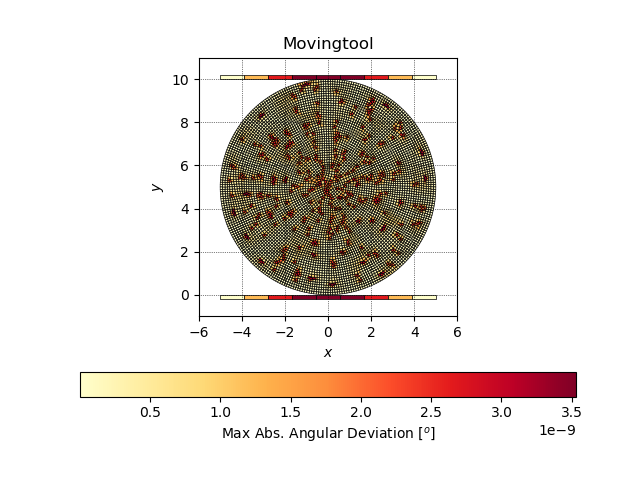

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [20]:
i = 1
fig = plt.figure()
parts_names = parts.keys()
for name, part in parts.items(): 
    mesh = part.mesh
    patches = mesh.to_polycollection(edgecolor = "black", linewidth = .5, alpha = 1.)
    stats = mesh.stats()
    patches.set_array( stats.stats.max_abs_angular_deviation )
    patches.set_cmap(mpl.cm.YlOrRd)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect("equal")
    #ax.set_xlim(mesh.nodes.coords.x.min(), mesh.nodes.coords.x.max())
    #ax.set_ylim(mesh.nodes.coords.y.min(), mesh.nodes.coords.y.max())
    ax.set_xlim(-6, 6)
    ax.set_ylim(-1,11)
    ax.add_collection(patches)
cbar = plt.colorbar(patches, orientation = "horizontal")
cbar.set_label("Max Abs. Angular Deviation [$^o$]")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid()
plt.title(name.title())
    #i+= 1
plt.show()


In [21]:
print("2: Processing -------------------------------------")
%time model_EF.run_simulation()

2: Processing -------------------------------------
#### RUNNING "BT" USING SOLVER "ABAQUS"
     Analysis initiated from SIMULIA established products
     Abaqus JOB BT
     Abaqus 3DEXPERIENCE R2018x
     Abaqus License Manager checked out the following licenses:
     Abaqus/Standard checked out 5 tokens from Flexnet server flex2-symme.univ-savoie.fr.
     <53 out of 90 licenses remain available>.
     Begin Analysis Input File Processor
     6/12/2019 11:58:03 AM
     Run pre.exe
     6/12/2019 11:58:32 AM
     End Analysis Input File Processor
     Begin Abaqus/Standard Analysis
     6/12/2019 11:58:32 AM
     Run standard.exe
     6/12/2019 12:12:10 PM
     Abaqus Error: Abaqus/Standard Analysis exited with an error - Please see the
     message file for possible error messages if the file exists.
     Begin Convert MFS to SFS
     6/12/2019 12:12:11 PM
     Run SMASimUtility.exe
     6/12/2019 12:12:11 PM
     End Convert MFS to SFS
     Abaqus/Analysis exited with errors
  => RAN

In [23]:
print("3: Postprocessing ---------------------------------")
%time model_EF.postproc()
print("4: Saving model -----------------------------------")
%time model_EF.save(workdir + "model_BT.pcklz")

3: Postprocessing ---------------------------------
#### POST-PROCESSING "BT" USING POST-PROCESSOR "ABAQUS"
     Abaqus License Manager checked out the following license(s):
     "cae" release 6.18 from flex2-symme.univ-savoie.fr
     <6 out of 9 licenses remain available>.
  => POST-PROCESSED BT: DURATION = 1866.19s >
Wall time: 32min 38s
4: Saving model -----------------------------------
Wall time: 1min 50s


In [ ]:
model_EF = ag.utils.load(workdir + "model_BT.pcklz")

## Simulation

## Post-Processing

### Time data


In [22]:
hist = model_EF.data["history"]
hist.head()

KeyError: 'history'

<IPython.core.display.Javascript object>


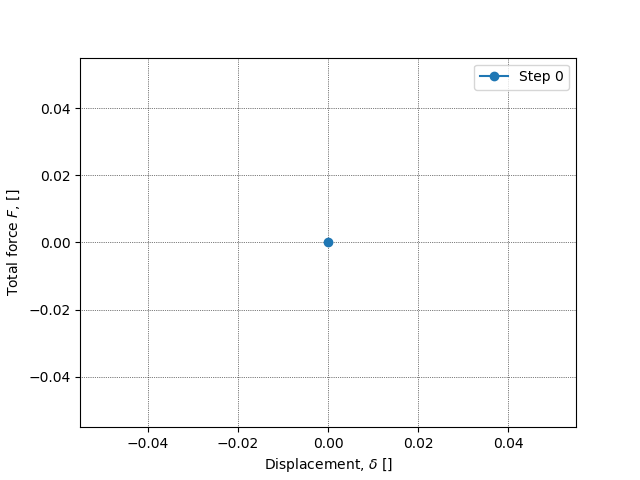

In [25]:
plt.figure()
for step, group in hist.groupby("step"):
  plt.plot(group.t, group.F,'o-', label = "Step {0}".format(step))
plt.grid()
plt.legend(loc = "best")
plt.ylabel("Total force $F$, []")
plt.xlabel("Displacement, $\delta$ []")
plt.show()

### Fields

In [ ]:
meta=model_EF.parts["sample"].mesh.fields_metadata()
meta

In [ ]:
#Frame number to plot
frame_num=1
parts = {k:part.mesh.copy() for k, part in model_EF.parts.items() }

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

field_num = meta[(meta.label=='PE') & (meta.frame==frame_num)].index[0]
disp_num  = meta[(meta.label=='U')  & (meta.frame==frame_num)].index[0]
levels = np.linspace(-.1, 0.005, 21)
dispMagnification = 1.

for k, mesh in parts.items():
    
    field =mesh.fields[field_num].data.v22
    disp = mesh.fields[disp_num].data
    frame = mesh.fields[disp_num].frame
    mesh.nodes[("coords", "x")] += dispMagnification*disp.v1
    mesh.nodes[("coords", "y")] += dispMagnification*disp.v2
    tri = mesh.to_triangulation()
    patches = mesh.to_polycollection(facecolor = "none",
                                     edgecolor = "black",
                                     linewidth = .02) 
    grad = ax.tricontourf(tri, field, levels, cmap = mpl.cm.jet, alpha = 1)
    ax.tricontour(tri, field, levels, colors = "white", linewidths = 0.01)
    #ax.tricontour(tri, field, 0, colors = "r", linewidths = 2)
    ax.add_collection(patches)

plt.title("Frame:{0}".format(frame))
ax.set_aspect("equal")
#ax.set_xlim(0, 55.)
#ax.set_ylim(-40, 20.)
cbar = plt.colorbar(grad)
cbar.set_label("$\epsilon^P_{22} (-)$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()



In [ ]:
parts = {k:part.mesh.copy() for k, part in model_EF.parts.items() }

fig = plt.figure()
ax = fig.add_subplot(1,1,1)


field_num = meta[(meta.label=='Seq') & (meta.frame==frame_num)].index[0]
disp_num  = meta[(meta.label=='U')  & (meta.frame==frame_num)].index[0]
levels = np.linspace(0, 1000, 21)
dispMagnification = 1.

for k, mesh in parts.items():
    
    field =mesh.fields[field_num].data.v
    disp = mesh.fields[disp_num].data
    frame = mesh.fields[disp_num].frame
    mesh.nodes[("coords", "x")] += dispMagnification*disp.v1
    mesh.nodes[("coords", "y")] += dispMagnification*disp.v2
    tri = mesh.to_triangulation()
    patches = mesh.to_polycollection(facecolor = "none",
                                     edgecolor = "black",
                                     linewidth = .05) 
    grad = ax.tricontourf(tri, field, levels, cmap = mpl.cm.jet, alpha = 1)
    ax.tricontour(tri, field, levels, colors = "white", linewidths = 0.05)
    #ax.tricontour(tri, field, 0, colors = "r", linewidths = 2)
    ax.add_collection(patches)

plt.title("Frame:{0}".format(frame))
ax.set_aspect("equal")
#ax.set_xlim(0, 55.)
#ax.set_ylim(-40, 20.)
cbar = plt.colorbar(grad)
cbar.set_label("$\sigma_{eq} (MPa)$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()